In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import seaborn as sns
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

import warnings
from time import time
import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras import metrics

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as sm

In [92]:
dataBlocks = []
# for num in range(1,112):
#     df = pd.read_csv("dane/halfhourly_dataset/block_"+str(num)+".csv")
#     dataBlocks.append(df)

#data = pd.concat(dataBlocks, ignore_index=True)

df = pd.read_csv("dane/halfhourly_dataset/block_0.csv")

data = df.loc[df["LCLid"] == "MAC000002"]

In [93]:
data['date_time'] = pd.to_datetime(data['tstp'])
data = data.dropna(subset=['energy(kWh/hh)'])
data = data[['LCLid', 'date_time', 'energy(kWh/hh)']]

C:\Users\Konrad\AppData\Local\Temp\ipykernel_20448\1794836604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_time'] = pd.to_datetime(data['tstp'])


In [94]:
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)
data['hour'] = data['date_time'].apply(lambda x: x.hour)
data['minute'] = data['date_time'].apply(lambda x: x.minute)

In [95]:
data = data.loc[:,['date_time','energy(kWh/hh)', 'year', 'quarter', 'month', 'day', 'hour', 'minute']]
data.sort_values('date_time', inplace=True, ascending=True)
data = data.reset_index(drop=True)
data['weekday'] = data['date_time'].apply(lambda x: x.weekday() < 5).astype(int)

In [96]:
data.head()

,date_time,energy(kWh/hh),year,quarter,month,day,hour,minute,weekday
0,2012-10-12 00:30:00,0,2012,4,10,12,0,30,1
1,2012-10-12 01:00:00,0,2012,4,10,12,1,0,1
2,2012-10-12 01:30:00,0,2012,4,10,12,1,30,1
3,2012-10-12 02:00:00,0,2012,4,10,12,2,0,1
4,2012-10-12 02:30:00,0,2012,4,10,12,2,30,1


In [97]:
data.tail()

,date_time,energy(kWh/hh),year,quarter,month,day,hour,minute,weekday
24136,2014-02-27 22:00:00,0.416,2014,1,2,27,22,0,1
24137,2014-02-27 22:30:00,1.35,2014,1,2,27,22,30,1
24138,2014-02-27 23:00:00,1.247,2014,1,2,27,23,0,1
24139,2014-02-27 23:30:00,1.2180001,2014,1,2,27,23,30,1
24140,2014-02-28 00:00:00,1.387,2014,1,2,28,0,0,1


In [98]:
print('Liczba wierszy i kolumn:', data.shape)
print('Najstarsza data:', data.date_time.min())
print('Najnowsza data:', data.date_time.max())

Liczba wierszy i kolumn: (24141, 9)
Najstarsza data: 2012-10-12 00:30:00
Najnowsza data: 2014-02-28 00:00:00


In [99]:
data = data.loc[data["energy(kWh/hh)"] != "Null"]

In [100]:
# energyPerDay = data.groupby('date_time')[['energy_sum']].sum()
# data.drop_duplicates(subset=['date_time'], keep='first', inplace=True)
# energyPerDay.reset_index()
# data = data.merge(energyPerDay, on='date_time', how='left')
# data.drop(['energy_sum_x'], inplace=True, axis=1)
# data.rename(columns={'energy_sum_y':'energy_sum'}, inplace=True)

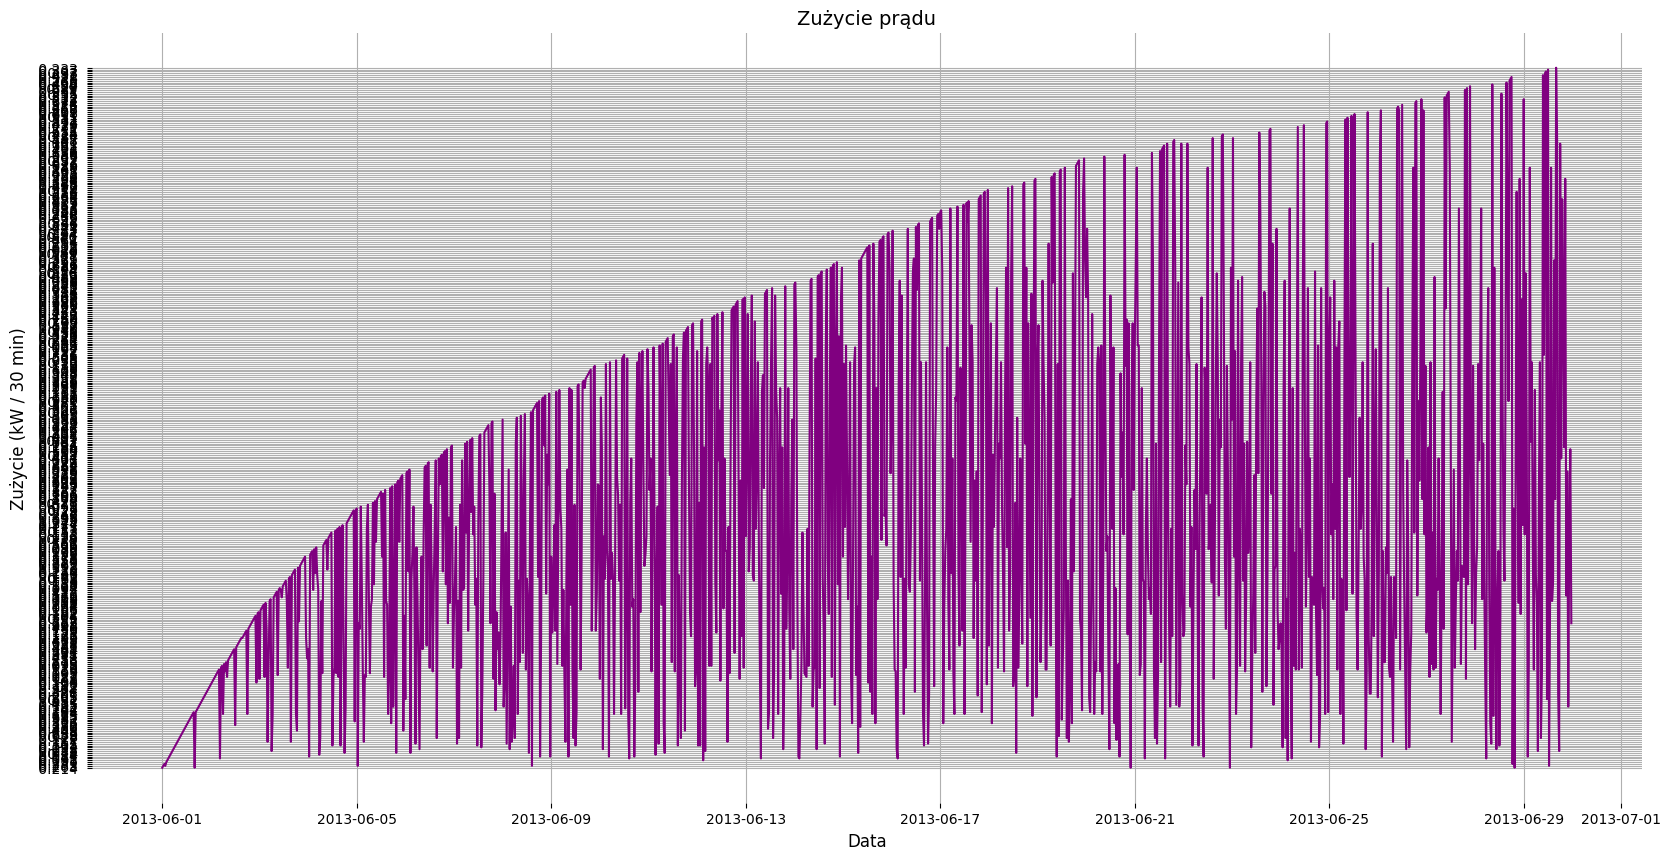

In [101]:
data1 = data[(data.date_time >= '2013-06-01') & (data.date_time < '2013-06-30')]
plt.figure(figsize=(20,10))
plt.plot(data1.date_time, data1["energy(kWh/hh)"], color='purple')
plt.ylabel('Zużycie (kW / 30 min)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.title('Zużycie prądu', fontsize=14)
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()

In [102]:
dataset = data["energy(kWh/hh)"].values.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) - 480)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [103]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [104]:
X_train, Y_train = create_dataset(train, 30)
X_test, Y_test = create_dataset(test, 30)
print(X_train.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(X_test.shape)

(23629, 30)
(449, 30)
(23629, 1, 30)
(449, 1, 30)


In [105]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=500, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=500, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid', kernel_constraint=MaxNorm(3)))

#sgd = SGD(learning_rate=0.2, momentum=0.9)
#model.compile(loss='mae', optimizer='rmsprop')
#model.compile(loss='mean_squared_error', optimizer='rmsprop')
#model.compile(loss=tf.keras.losses.MeanSquaredError(reduction="none"), optimizer='adam')
model.compile(loss='mae', optimizer='adam')


history = model.fit(X_train, Y_train, epochs=100, batch_size=96, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

Epoch 1/100


c:\Users\Konrad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 - 5s - 21ms/step - loss: 0.0774 - val_loss: 0.0627
Epoch 2/100
247/247 - 3s - 11ms/step - loss: 0.0423 - val_loss: 0.0439
Epoch 3/100
247/247 - 3s - 11ms/step - loss: 0.0367 - val_loss: 0.0400
Epoch 4/100
247/247 - 3s - 11ms/step - loss: 0.0354 - val_loss: 0.0379
Epoch 5/100
247/247 - 3s - 11ms/step - loss: 0.0354 - val_loss: 0.0377
Epoch 6/100
247/247 - 3s - 11ms/step - loss: 0.0354 - val_loss: 0.0377
Epoch 7/100
247/247 - 3s - 11ms/step - loss: 0.0347 - val_loss: 0.0379
Epoch 8/100
247/247 - 3s - 11ms/step - loss: 0.0346 - val_loss: 0.0381
Epoch 9/100
247/247 - 3s - 11ms/step - loss: 0.0349 - val_loss: 0.0365
Epoch 10/100
247/247 - 3s - 11ms/step - loss: 0.0344 - val_loss: 0.0362
Epoch 11/100
247/247 - 3s - 11ms/step - loss: 0.0340 - val_loss: 0.0357
Epoch 12/100
247/247 - 3s - 11ms/step - loss: 0.0339 - val_loss: 0.0361
Epoch 13/100
247/247 - 3s - 11ms/step - loss: 0.0338 - val_loss: 0.0356
Epoch 14/100
247/247 - 3s - 11ms/step - loss: 0.0337 - val_loss: 0.0354
Epoch 15/100


In [106]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 1, 100)         │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1, 500)         │     1,202,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 1, 500)         │     2,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100)            │       240,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,490,705 (40.02 MB)

 Trainable params: 3,496,901 (13.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,993,804 (26.68 MB)

In [107]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Średni błąd bezwzględny na zbiorze testowym:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym: ',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Średni błąd bezwzględny na zbiorze treningowym:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

739/739 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Średni błąd bezwzględny na zbiorze testowym: 0.08533329299030659
Pierwiastek z błędu średniokwadratowego na zbiorze testowym:  0.17929296449318252
Średni błąd bezwzględny na zbiorze treningowym: 0.09203250801997688
Pierwiastek z błędu średniokwadratowego na zbiorze testowym: 0.17556711689843557


In [108]:
print("R2 score =", round(sm.r2_score(Y_test[0], test_predict[:,0]), 2))

R2 score = 0.52


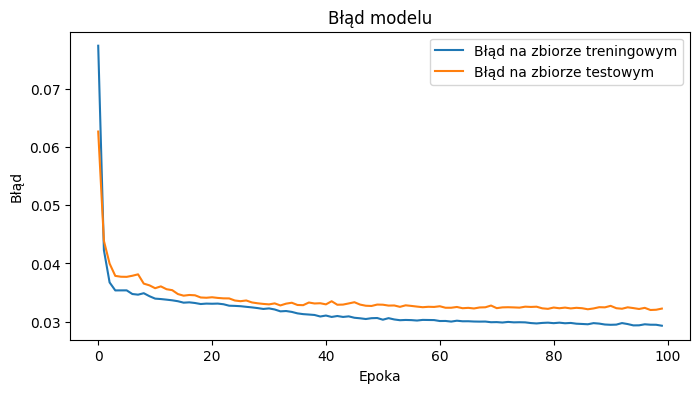

In [109]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Błąd na zbiorze treningowym')
plt.plot(history.history['val_loss'], label='Błąd na zbiorze testowym')
plt.title('Błąd modelu')
plt.ylabel('Błąd')
plt.xlabel('Epoka')
plt.legend(loc='upper right')
plt.show()

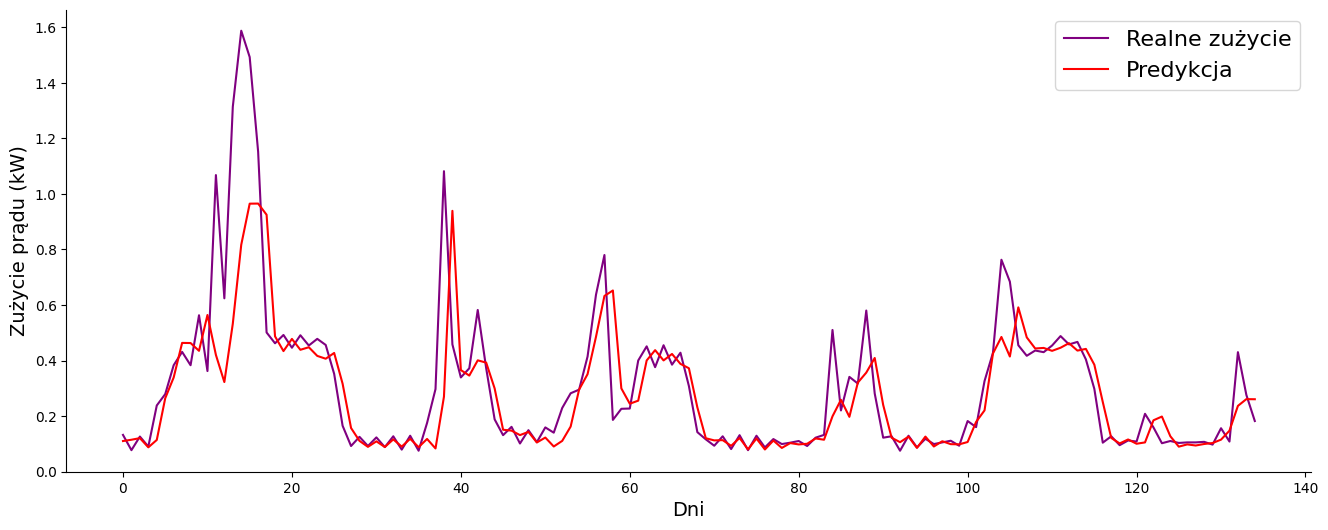

In [110]:
aa=[x for x in range(135)]
                    
plt.figure(figsize=(15,6))
plt.plot(aa, Y_test[0][:135], label="Realne zużycie", color='purple')
plt.plot(aa, test_predict[:,0][:135], label="Predykcja", color='red')
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Zużycie prądu (kW)', size=14)
plt.xlabel('Dni', size=14)
plt.legend(fontsize=16)
plt.show()

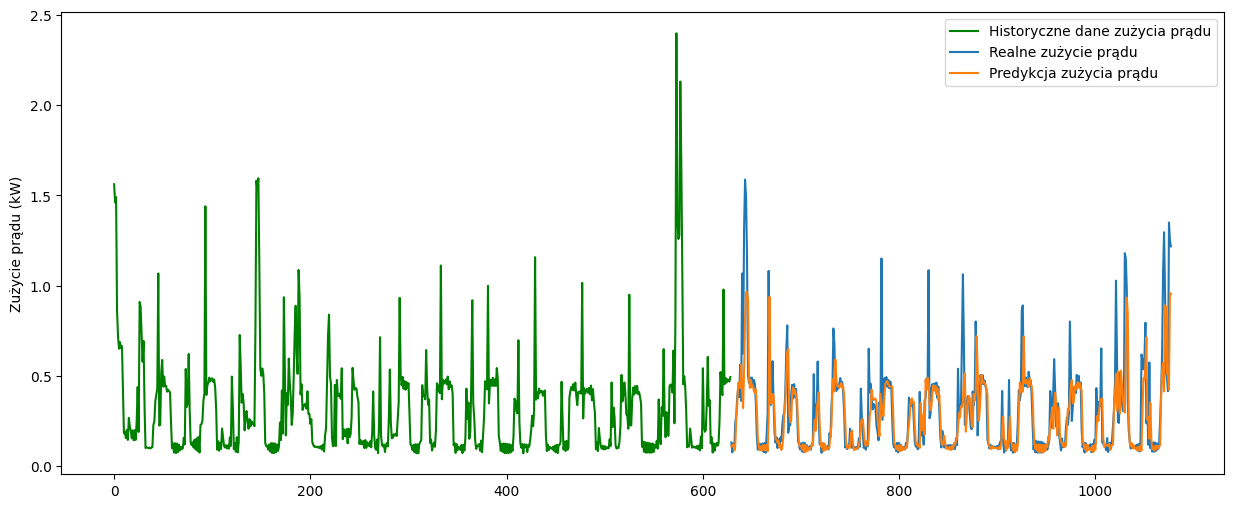

In [111]:
aa=[x for x in range(30)]
plt.figure(figsize=(15,6))
plt.plot(np.arange(0, len(Y_train[0][23000:23630])), Y_train[0][23000:23630], 'g', label="Historyczne dane zużycia prądu")
plt.plot(np.arange(len(Y_train[0][23000:23630]), len(Y_train[0][23000:23630]) + len(Y_test[0])), Y_test[0], label="Realne zużycie prądu")
plt.plot(np.arange(len(Y_train[0][23000:23630]), len(Y_train[0][23000:23630]) + len(Y_test[0])), test_predict[:,0], label="Predykcja zużycia prądu")
plt.ylabel('Zużycie prądu (kW)')
plt.legend()
plt.show()